In [18]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
import gc

# Utils

In [19]:
# plot training history function
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [20]:
DIR_PATH = "/kaggle/input/rwf2000/RWF-2000"
TRAIN_DIR = os.path.join(DIR_PATH, "train")
TEST_DIR = os.path.join(DIR_PATH, "val")

In [21]:
CLASS_NAMES = os.listdir(TRAIN_DIR)
SEED = 1337
BATCH_SIZE = 10

ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50 + 1
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

In [22]:
# get list of labels and video path
def get_labels_and_video_paths(data_dir):
    labels = []
    video_paths = []
    for label in CLASS_NAMES:
        label_dir = os.path.join(data_dir, label)
        for video in os.listdir(label_dir):
            video_paths.append(os.path.join(label_dir, video))
            labels.append(label)
    return labels, video_paths

## Load Data

In [23]:
import gc

def load_videos(video_IDs: list, video_labels: dict, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)
    labels = np.empty((len(video_IDs),), dtype=np.int8)

    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))

    for i, video_ID in enumerate(video_IDs):
        cap = cv2.VideoCapture(video_ID)
        frames = []
        index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if index in frames_idx:
                frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
                if normalize:
                    frame /= 255.0
                frames.append(frame)
            index += 1
        cap.release()

        videos[i,] = np.array(frames)
        labels[i] = video_labels[video_ID]

    return videos, labels

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        bacth_IDs = self.video_IDs[idx*self.batch_size:(idx+1)*self.batch_size]

        return load_videos(bacth_IDs, self.video_labels, self.video_frames, self.video_width, self.video_height, self.video_channels, self.dtype, self.normalize)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        # Clear memory after epochs
        gc.collect()
        #K.clear_session()

In [24]:
import glob

train_video_IDs = glob.glob(f"{DIR_PATH}/train/*/*")
train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_IDs = glob.glob(f"{DIR_PATH}/val/*/*")
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}

train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=BATCH_SIZE)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=BATCH_SIZE)

In [25]:
@tf.keras.utils.register_keras_serializable(package="FrameDifference")
class FrameDifference(layers.Layer):
    def __init__(self, **kwargs):
        super(FrameDifference, self).__init__(**kwargs)

    def call(self, video):
        return video[:, 1:] - video[:, :-1]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] - 1) + input_shape[2:]

# Training Model

In [27]:
def create_model():
    # Input layer
    inputs = layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

    # Apply Frame Difference using the custom layer
    x = FrameDifference()(inputs)
        
    # ConvLSTM2D block 1
    x = layers.ConvLSTM2D(
        filters=4,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        recurrent_dropout=0.3,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        data_format='channels_last'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = layers.TimeDistributed(layers.Dropout(0.3))(x)

    # ConvLSTM2D block 2
    x = layers.ConvLSTM2D(
        filters=8,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=True,
        recurrent_dropout=0.3,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        data_format='channels_last'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(x)
    x = layers.TimeDistributed(layers.Dropout(0.3))(x)

    # ConvLSTM2D block 3
    x = layers.ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False,
        recurrent_dropout=0.3,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        data_format='channels_last'
    )(x)
    x = layers.BatchNormalization()(x)

    # Depthwise Convolution
    x = layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu', data_format='channels_last')(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(data_format='channels_last')(x)

    # Fully Connected Dense Layers
    x = layers.Dense(units=128, activation='relu')(x)
    x = layers.Dense(units=16, activation='relu')(x)

    # Output layer
    outputs = layers.Dense(units=1, activation='sigmoid')(x)

    # Define and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 51, 100, 100,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ frame_difference_1              │ (None, 50, 100, 100,   │             0 │
│ (FrameDifference)               │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 50, 100, 100,   │         1,024 │
│                                 │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 100, 100,   │            16 │
│ (BatchNormalization)            │ 4)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 50, 50, 50, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 50, 50, 50, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_8 (ConvLSTM2D)      │ (None, 50, 50, 50, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 50, 50, 50, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 50, 25, 25, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 50, 25, 25, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)      │ (None, 25, 25, 16)     │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 25, 25, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 23, 23, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,137 (98.19 KB)

 Trainable params: 25,081 (97.97 KB)

 Non-trainable params: 56 (224.00 B)

In [28]:
PATH_CHECKPOINT = '/kaggle/working/checkpoint/frame_difference_best_model.keras'

In [29]:
# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-6)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=PATH_CHECKPOINT,
                                                 save_best_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 verbose=1)

In [30]:
EPOCH = 40

# train the model
train_hist = model.fit(train_generator, validation_data = test_generator, epochs = EPOCH, callbacks=[early_stopping, lr_scheduler, cp_callback])

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729318531.140407      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_7', 192 bytes spill stores, 192 bytes spill loads



160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4889 - loss: 0.8560
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /kaggle/working/checkpoint/frame_difference_best_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - accuracy: 0.4888 - loss: 0.8556 - val_accuracy: 0.5000 - val_loss: 0.7177 - learning_rate: 0.0010
Epoch 2/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5965 - loss: 0.6660
Epoch 2: val_accuracy improved from 0.50000 to 0.60500, saving model to /kaggle/working/checkpoint/frame_difference_best_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 525s 3s/step - accuracy: 0.5969 - loss: 0.6658 - val_accuracy: 0.6050 - val_loss: 0.8038 - learning_rate: 0.0010
Epoch 3/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7407 - loss: 0.5638
Epoch 3: val_accuracy improved from 0.60500 to 0.77000, saving model to /kaggle/working/checkpoint/frame_difference_best_model.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.7407 - loss: 0.5638 

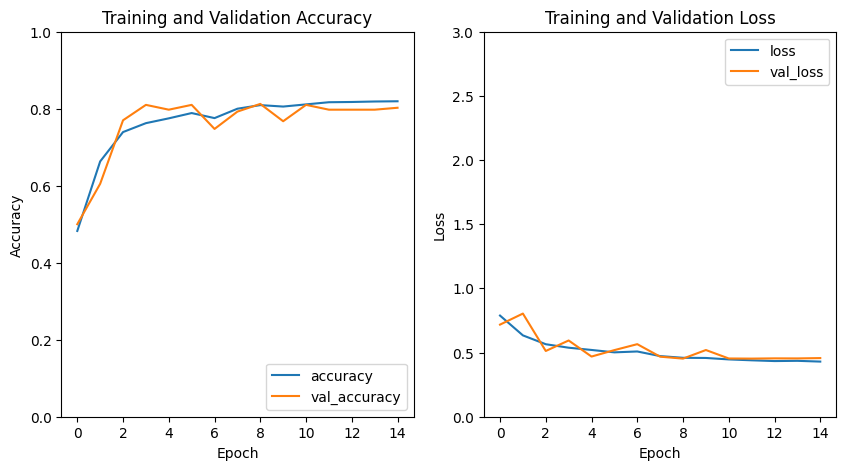

In [31]:
plot_training_history(train_hist)

# Evaluate

In [32]:
max_val_acc = max(train_hist.history['val_accuracy'])

print(f"max val accuracy: {(max_val_acc * 100):.4f}")

max val accuracy: 81.2500


In [33]:
model_eval = tf.keras.models.load_model(PATH_CHECKPOINT)

In [34]:
test_loss, test_acc = model_eval.evaluate(test_generator, verbose=0)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8125
Test Loss: 0.4528
